In [63]:
import torch 
from torch import nn 
from torch.optim import Adam 
import torchvision.transforms as transforms 
from torchvision import models
from torch.utils.data import Dataset, DataLoader 
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt 
from PIL import Image 
import pandas as pd 
import os
import numpy as np


In [64]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
train_df=pd.read_csv("/kaggle/input/bean-leaf-lesions-classification/train.csv")
val_df=pd.read_csv("/kaggle/input/bean-leaf-lesions-classification/val.csv")
data_df=pd.concat([train_df,val_df],ignore_index=True)
data_df['image:FILE']="/kaggle/input/bean-leaf-lesions-classification/"+data_df['image:FILE']
print("Data shape is:",data_df.shape)
print()
data_df.head()

Data shape is: (1167, 2)



,image:FILE,category
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,0
3,/kaggle/input/bean-leaf-lesions-classification...,0
4,/kaggle/input/bean-leaf-lesions-classification...,0


In [66]:
print("classes are:")
print(data_df['category'].unique())
print()
print("classes distribution are:")
print(data_df['category'].value_counts())


classes are:
[0 1 2]

classes distribution are:
category
2    393
1    389
0    385
Name: count, dtype: int64


In [67]:
train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)

In [68]:
label_encoder=LabelEncoder()
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [69]:
class CustomD(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [70]:
test_dataset=CustomD(dataframe=train,transform=transform)
train_dataset=CustomD(dataframe=test,transform=transform)


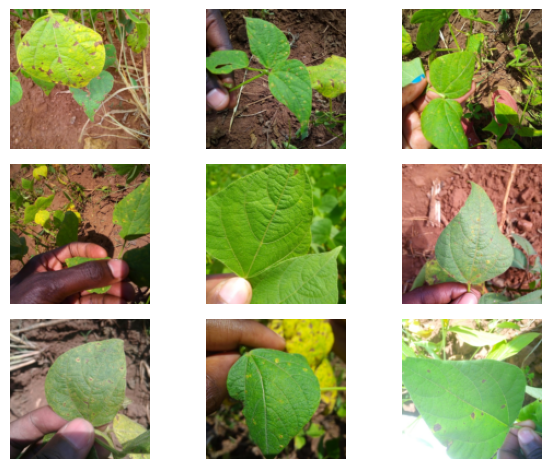

In [71]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [80]:
lr=1e-3
EPOCHS=10

In [73]:
train_loader=DataLoader(train_dataset,batch_size=6,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=6,shuffle=True)


In [74]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [75]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [76]:
num_classes=len(data_df['category'].unique())
googlenet_model.fc=torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [77]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(googlenet_model.parameters(),lr=lr)

In [81]:
total_loss_train_plot=[]
total_acc_train_plot=[]
for epoch in range(epochs):
    total_acc_train=0
    total_loss_train=0
    for (inputs,labels)  in train_loader:
        optimizer.zero_grad()
        outputs=googlenet_model(inputs)
        train_loss=criterion(outputs,labels)
        total_loss_train+=train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
    print()

Epoch 1/10, Train Loss: 0.2424 Train Accuracy 84.8571%

Epoch 2/10, Train Loss: 0.2929 Train Accuracy 82.2857%

Epoch 3/10, Train Loss: 0.2665 Train Accuracy 80.8571%

Epoch 4/10, Train Loss: 0.2541 Train Accuracy 82.5714%

Epoch 5/10, Train Loss: 0.1925 Train Accuracy 90.0%

Epoch 6/10, Train Loss: 0.2278 Train Accuracy 86.2857%

Epoch 7/10, Train Loss: 0.2229 Train Accuracy 85.7143%

Epoch 8/10, Train Loss: 0.2282 Train Accuracy 86.0%

Epoch 9/10, Train Loss: 0.1995 Train Accuracy 87.7143%

Epoch 10/10, Train Loss: 0.1893 Train Accuracy 90.2857%



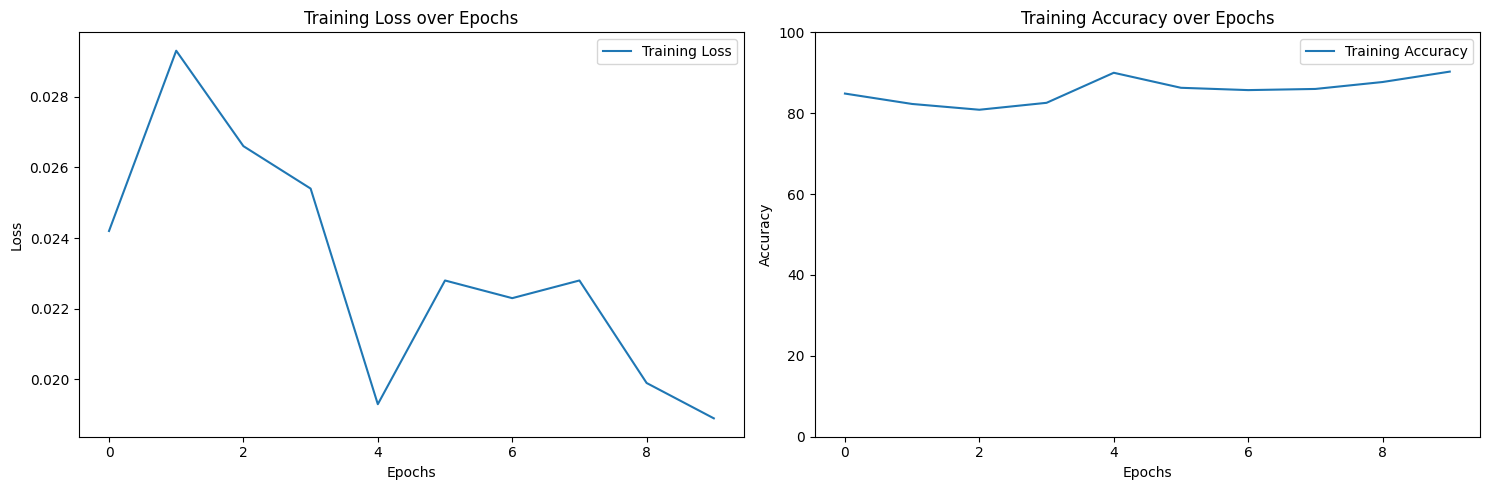

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()